### Is this mushroom edible? Try it!

<br>
<img src="https://raw.githubusercontent.com/YData123/sds265-fa21/main/demos/classification/mushrooms.jpg" width="110" align="left" style="margin:10px 15px">

Have you every gone for a walk in the woods and been tempted to bring back some mushrooms for your dinner salad? Well, you may then wonder how many edible or poisonous mushrooms you might need to be shown before you could confidently forage in the forest on your own. We'll first load a database of mushrooms that have been hand-classified according to whether or not they are poisonous. Then, we'll put it into a form suitable for logistic regression by converting all of the categorical variables to "dummy" variables using a "1-hot" representation. Then we'll fit logistic regression models on training sets of increasing size.


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
data = pd.read_csv('https://raw.githubusercontent.com/YData123/sds265-fa23/main/demos/classification/mushrooms.csv')
data.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


A description of these mushroom data can be found [here](https://archive.ics.uci.edu/ml/datasets/Mushroom).

In [6]:
data['class'] = LabelEncoder().fit_transform(data['class'])
encoded_data = pd.get_dummies(data)
encoded_data.head()

# convert data to binary --> can treat as numerical (1 or 0)

,class,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_f,cap-surface_g,cap-surface_s,...,population_s,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
0,1,False,False,False,False,False,True,False,False,True,...,True,False,False,False,False,False,False,False,True,False
1,0,False,False,False,False,False,True,False,False,True,...,False,False,False,False,True,False,False,False,False,False
2,0,True,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,True,False,False,False
3,1,False,False,False,False,False,True,False,False,False,...,True,False,False,False,False,False,False,False,True,False
4,0,False,False,False,False,False,True,False,False,True,...,False,False,False,False,True,False,False,False,False,False



The transformation is mapping each categorical variable to a series of 1-hot or "dummy" variables,
so the weights are meaningful in a logistic regression model.



Next, we convert this DataFrame to numpy arrays, suitable for input to sklearn.

In [7]:
y = encoded_data['class'].values
X = encoded_data.drop('class', axis=1).values


#### Dimensions of the data

Ok, now before we get to work building a classifier, let's look at some
of the characteristics of the data. Following code finds
the number of data points, number of predictor variables, the number of
expanded predictors, and percentage of poisonous mushrooms in the data.

In [8]:
num_data_points = X.shape[0]
num_original_predictors = data.shape[1]-1
num_expanded_predictors = X.shape[1]
poisonous = np.mean(y)*100

print("Number of data points: %d" % num_data_points)
print("Number of original predictors: %d" % num_original_predictors)
print("Number of expanded predictors: %d" % num_expanded_predictors)
print("Percent poisonous: %.1f%%" % poisonous)

Number of data points: 8124
Number of original predictors: 22
Number of expanded predictors: 117
Percent poisonous: 48.2%


#### Fitting logistic regression models

Next, we will construct a series of logistic regression models with an increasing number of training points. Specifically, we will:

* let the sample size $n$ vary from 10 to 400 in increments of 1
* for each $n$ train a logistic regression model on $n$ randomly selected training points, and test on the remaining data
* for each $n$, do this 10 times and average the error rates
* plot the resulting average error rates as a function of $n$

Some notes:

* We will use the function `sklearn.model_selection.train_test_split` in each trial to randomly split the data into training and test sets. For example, you can use `train_test_split(X, y, train_size=n)`
* The implementation only requires about 10-15 lines of code.

100%|██████████| 196/196 [00:46<00:00,  4.21it/s]


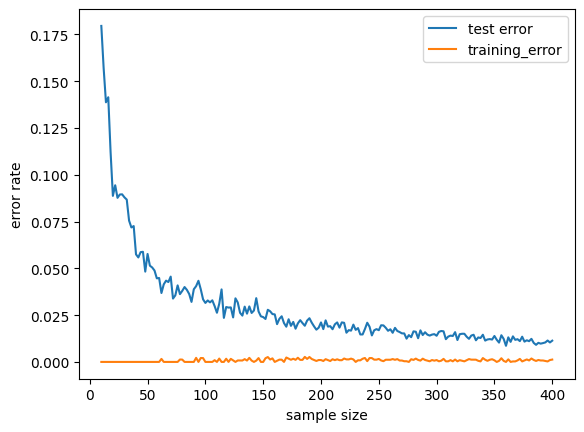

In [9]:
# fit a logistic regression
trials = 10
sample_size = np.arange(10, 401, 2) # do a random split of training and test data 10 times

from tqdm import tqdm # allows you to see progress as running
error_rate = []
train_error_rate = []
lr = LogisticRegression(solver='lbfgs') #scikit linear models
for n in tqdm(sample_size): # want to see accuracy of classifier as you get more and more data, aka learning curve
    err = []
    train_err = []
    for trial in np.arange(trials): # split dataset into 2 pieces, train and set, n = train data set size
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=n)
        lr.fit(X_train, y_train)
        this_err = np.mean(lr.predict(X_test) != y_test) # risk on test set
        err.append(this_err)
        this_err = np.mean(lr.predict(X_train) != y_train) # risk on training set
        train_err.append(this_err)
    error_rate.append(np.mean(err))
    train_error_rate.append(np.mean(train_err))

plt.plot(sample_size, error_rate, label='test error')
plt.plot(sample_size, train_error_rate, label='training_error')
plt.xlabel('sample size')
plt.legend()
_ = plt.ylabel('error rate')

# not overfitting because we don't see the test error going up as sample size continues to grow
# gives us a sample size we need to get a target test_error rate
# ex. want to be 99% sure, then look at 0.01 error rate sample size

####  Sample sizes to get 5% and 1% error

We now ask how many data points are required before the error falls below 5 percent? Below 1 percent?


In [ ]:
e = np.array(error_rate)

n_05 = np.min(sample_size[np.where(e < 0.05)])
print("%d samples are required before the error falls below 5%%" % n_05)

n_01 = np.min(sample_size[np.where(e < 0.01)])
print("%d samples are required before the error falls below 1%%" % n_01)

52 samples are required before the error falls below 5%
326 samples are required before the error falls below 1%


### Flower power: Logistic regression on the Iris data

<img src="https://raw.githubusercontent.com/YData123/sds265-fa21/main/demos/classification/irises.png" width="500" align="top">

We'll now carry out logistic regression for classification of the iris data.



The following cell plots the original data in terms of sepal and petal dimensions.

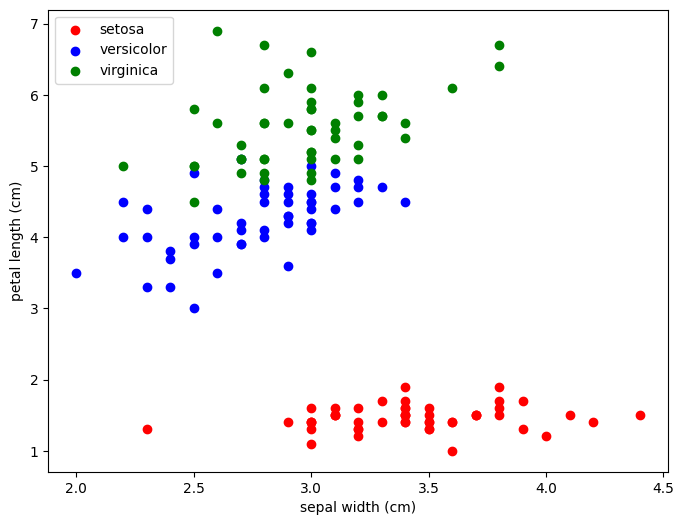

In [11]:
from sklearn.datasets import load_iris

fig = plt.figure(figsize=(8,6))
iris = load_iris()
x_index = 1
y_index = 2
ax = fig.add_subplot(111)
colors = ['red', 'blue', 'green']
for c in np.arange(3):
    mask = (iris.target==c)
    plt.scatter(iris.data[mask, x_index], iris.data[mask, y_index], color=colors[c], label=iris.target_names[c])

plt.xlabel(iris.feature_names[x_index])
plt.ylabel(iris.feature_names[y_index])
plt.legend(loc='upper left')
plt.show()

#### Training logistic regression models

We'll construct a series of logistic regression models using an increasing number of training points.
Specifically, we will

* let the sample size 10% of the data to 90% of the data, in increments of 10%
* for each sample size, train a logistic regression model on randomly selected training points, and test on the remaining data
* For each sample size, run 1000 trials and average the error rates
* Plot the resulting average error rates as a function of sample percentage of the data

Some notes:

* As before, we will use the function sklearn.model_selection.train_test_split in each trial to randomly split the data into training and test sets. For example, you can use train_test_split(X, y, train_size=.1)
* We now use `lr = LogisticRegression(multi_class='multinomial')` to fit a logistic regression model to predict the three class labels (*versicolor*, *virginica*, and *setosa*). This is a linear model of the log-odds, just as for binary logistic regression. The decision boundaries will be linear functions of the four predictor variables.
* In a little more detail, in a logistic regression model to carry out three-way classification where $Y$ can be 0, 1, or 2, the model takes the form
$$ P(Y=0 \,|\, x) = \frac{1}{1 + e^{\beta_1^T x} + e^{\beta_2^T x}}$$
<br>
$$ P(Y=1 \,|\, x) = \frac{e^{\beta_1^T x}}{1 + e^{\beta_1^T x} + e^{\beta_2^T x}}$$
<br>
$$ P(Y=2 \,|\, x) = \frac{e^{\beta_2^T x}}{1 + e^{\beta_1^T x} + e^{\beta_2^T x}}$$
<br>
* The decision boundaries between any two classes in such a model are linear.


100%|██████████| 9/9 [00:09<00:00,  1.02s/it]


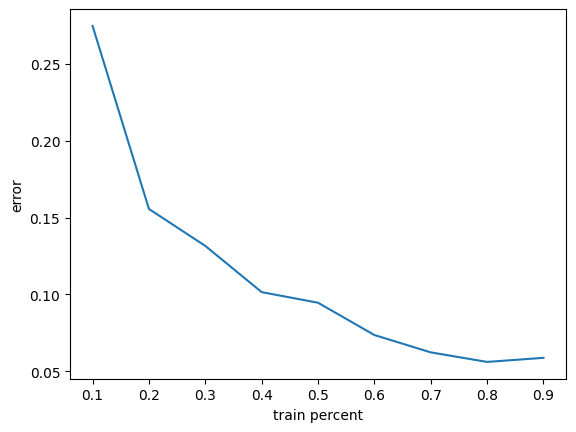

In [17]:
# contains a series of fits like for mushroom data
# x is measurements, y is target
# construct a logistic regression model

X = iris.data
y = iris.target

lr = LogisticRegression(penalty='l2', C=0.1)
#lr = LogisticRegression(penalty='l2', C=.1, multi_class='multinomial')
# note: regularization uses a penalty with parameter C, which is 1/lambda --> so .1 is a regularization of 10
# what if you made C = 100 --> get a ton of warnings --> parameters are running off to infinity
# algorithm isn't converging - complaining that you need to increase number of iterations
# this is due to gap between setosa and other species
# so do more regularization by decreasing C

lr_error_rate = []
trials = 100
train_percent = np.linspace(.1,.9,num=9) # split data based on percentage


# your code here
from tqdm import tqdm
for p in tqdm(train_percent):
    errs = [] # average error rates over 100 trials
    for trial in np.arange(trials):
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=p)
        lr.fit(X_train, y_train)
        err = np.mean(lr.predict(X_test) != y_test)
        errs.append(err)
    this_err = np.mean(errs)
    lr_error_rate.append(this_err)

plt.plot(train_percent, lr_error_rate)
plt.xlabel('train percent')
_ = plt.ylabel('error')

In [ ]:
X.shape

(150, 4)

#### Finding the minimum error

What is the smallest average error attained by logistic regression?

In [14]:
min_error = np.min(np.array(lr_error_rate))
print("The minimum error attained by the logistic regression is %.2f%%" % (100*min_error))

The minimum error attained by the logistic regression is 5.53%


### Your turn!

As an exercise to solidfy your understanding of some of the concepts and coding above, please now modify the code to put error bars on the above learning curves. Specifically, estimate the standard deviation of the training error, and put bars at each point at plus/minus one or two standard deviations. What do the results say about the level of uncertainty?